In [1]:
import pandas as pd
import re

In [2]:
df = pd.read_csv('../../metrics/statistical_test_results.csv')

In [3]:
df.head()

,index,kpss,ocsb-10,ocsb-20,ocsb-30,ocsb-40,ocsb-50,ocsb-60,ocsb-70,ocsb-80,...,ocsb-1410,ocsb-1420,ocsb-1430,ocsb-1440,ocsb-1450,ocsb-1460,ocsb-1470,ocsb-1480,ocsb-1490,white
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,4,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [4]:
train = pd.read_csv('../../data/train.csv')
test = pd.read_csv('../../data/test.csv')

In [5]:
all_data = pd.concat([train, test]).reset_index(drop = True).reset_index() \
  .melt(id_vars = ['index'])

all_data['index'] = all_data['index'].astype('category')
all_data['variable'] = all_data['variable'].apply(lambda x : re.sub('FLUX\\.', '', x))
all_data.head()

,index,variable,value
0,0,LABEL,2.0
1,1,LABEL,2.0
2,2,LABEL,2.0
3,3,LABEL,2.0
4,4,LABEL,2.0


In [6]:
label_df = all_data.loc[
  (all_data['variable'] == 'LABEL')
  , :].rename(columns = {'value' : 'label'}) \
  .assign(label = lambda x : x['label'] - 1)[['index', 'label']]
label_df['label'] = label_df['label'].apply(lambda x : bool(x))
label_df.head()

,index,label
0,0,True
1,1,True
2,2,True
3,3,True
4,4,True


In [7]:
statistical_test_results_labeled = pd.merge(label_df, df, on = 'index')
statistical_test_results_labeled.head()

,index,label,kpss,ocsb-10,ocsb-20,ocsb-30,ocsb-40,ocsb-50,ocsb-60,ocsb-70,...,ocsb-1410,ocsb-1420,ocsb-1430,ocsb-1440,ocsb-1450,ocsb-1460,ocsb-1470,ocsb-1480,ocsb-1490,white
0,0,True,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,True,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,True,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,3,True,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,4,True,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


# KPSS

In [13]:
kpss_results = statistical_test_results_labeled[['label', 'kpss']].groupby(by = ['label', 'kpss']).size().to_frame(name = 'count').reset_index()

In [16]:
kpss_results

,label,kpss,count
0,False,0,1985
1,False,1,3609
2,False,2,21
3,True,0,11
4,True,1,29
5,True,2,2


# White

In [15]:
white_results = statistical_test_results_labeled[['label', 'white']].groupby(by = ['label', 'white']).size().to_frame(name = 'count').reset_index()

In [17]:
white_results

,label,white,count
0,False,0,2070
1,False,1,3545
2,True,0,12
3,True,1,30


# OCSB

In [8]:
ocsb_results = statistical_test_results_labeled[statistical_test_results_labeled.columns[pd.Series(statistical_test_results_labeled.columns).str.startswith(('label', 'ocsb'))]] \
  .melt(id_vars = ['label'])
# Convert strings (ocsb-frequency) to number (frequency)
ocsb_results['variable'] = pd.to_numeric(ocsb_results['variable'].apply(lambda x : x.replace('ocsb-', '')))
# Group by and calculate value counts
ocsb_results = ocsb_results.groupby(by = ['label', 'variable', 'value']).size().to_frame(name = 'count').reset_index()
# Drop all rows where ocsb result was 0 - not important for analysis
ocsb_results = ocsb_results[ocsb_results.value > 0]
# To simplify plot analysis - legend levels
ocsb_results['value'] = ocsb_results['value'].astype('category')
ocsb_results

,label,variable,value,count
10,False,100,1,1
17,False,160,1,1
19,False,170,1,1
27,False,240,1,1
30,False,260,1,1
...,...,...,...,...
288,False,1470,2,9
290,False,1480,1,4
291,False,1480,2,3
293,False,1490,1,1


In [11]:
ocsb_results['label'] = ocsb_results['label'].apply(lambda x : 'Stars without exoplanets' if x == False else 'Stars with exoplanets')

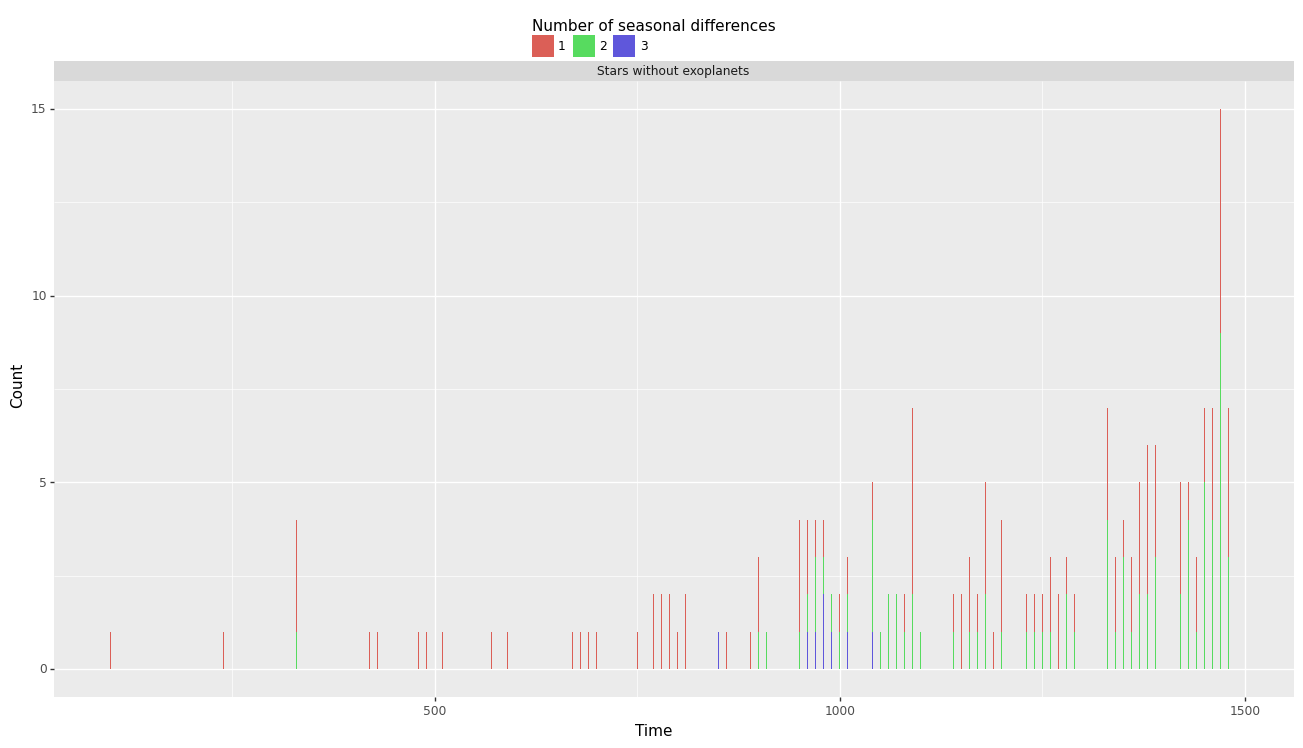

<ggplot: (798298173)>

In [12]:
import plotnine as p9
p9.ggplot(ocsb_results,
  p9.aes(x = 'variable', y = 'count', fill = 'value')
  ) + \
  p9.theme_gray() + \
  p9.geom_bar(stat = 'identity') + \
  p9.ylab('Count') + \
  p9.xlab('Time') + \
  p9.facet_wrap(facets = '~label', ncol = 1, scales = 'free') + \
  p9.labs(fill = 'Number of seasonal differences') + \
  p9.theme(
    legend_position = 'top',
    legend_box_spacing = 0,
    legend_box_margin = 1,
    subplots_adjust = {
      'hspace' : 0.15
    },
    figure_size = (16, 8),
  )